### Read Data from files

In [1]:
import numpy as np

def read_data_file(data_file: str) -> np.ndarray:

    with open(data_file, "r") as file:

        my_data = []

        for x in file:
            # Saving coordinates using a new format
            my_data.append(x.strip("\n}{").split(","))

        my_data_np = np.array(my_data, dtype=float)

    return my_data_np

I_measured_273K  = read_data_file("elektro_files/G4_274_5K_BB.0.dpt")
I_measured_293K = read_data_file("elektro_files/G4_293K_BB.0.dpt")
I_measured_313K = read_data_file("elektro_files/G4_313_03K_BB.0.dpt")
I_measured_343K = read_data_file("elektro_files/G4_343_07K_BB.0.dpt")
I_measured_355K = read_data_file("elektro_files/G4_355_00K_BB.0.dpt")

I_stomach = read_data_file("elektro_files/G4_STOMACH.0.dpt")
I_sky = read_data_file("elektro_files/G4_SKY.0.dpt")
I_wall_surface = read_data_file("elektro_files/G4_WALL_SURFACE.0.dpt")
I_wall_surface_outside = read_data_file("elektro_files/G4_WALL_SURFACE_OUTSIDELAB.0.dpt")
I_additional_surface_outside = read_data_file("elektro_files/G4_ADDITIONAL_SURFACE_OUTSIDELAB.0.dpt")

A = read_data_file("elektro_files/EANZNH3100ppmm1cm-1.dpt")

I_stomach_empty = read_data_file("elektro_files/G4_STOMACH_EMPTYBUCKET.0.dpt")
I_stomach_ammonia = read_data_file("elektro_files/G4_STOMACH_AMMONIA.0.dpt")
I_sky_ammonia = read_data_file("elektro_files/G4_SKY_AMMONIA.0.dpt")

### Plot data functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection


def plot_points(my_data, my_data2, my_data3, my_data4, my_data5: np.ndarray, flag: bool = False) -> Axes:

    # Create a new figure
    fig = plt.figure(figsize = (15, 15))

    # Add points to the plot with some style
    plt.plot(my_data[:, 0], my_data[:, 1], color="blue", lw="0.8")
    plt.plot(my_data2[:, 0], my_data2[:, 1], color="red", lw="0.8")
    plt.plot(my_data3[:, 0], my_data3[:, 1], color="green", lw="0.8")
    plt.plot(my_data4[:, 0], my_data4[:, 1], color="yellow", lw="0.8")
    plt.plot(my_data4[:, 0], my_data5[:, 1], color="black", lw="0.8")


    # Save axes to new collection
    axes: Axes = plt.gca()

    # Add title and custom legend to the figure
    axes.set_title('Black Body Emissions')

    plt.xlabel("wave number")
    plt.ylabel("measured intensity")

    custom_lines =[
        Line2D([0], [0], color="blue", lw=2),
        Line2D([0], [0], color="red", lw=2),
        Line2D([0], [0], color="green", lw=2),
        Line2D([0], [0], color="yellow", lw=2),
        Line2D([0], [0], color="black", lw=2)
        ]

    axes.legend(custom_lines, ['274.5K', '293K', '313K', '343K', '355K'])

    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.25)

    # if 'flag' is not 0 then show the plot
    if flag:
        plt.show()

    else:
        plt.close()

    return axes


def plot_calibrated_spectra_comparison(my_data: np.ndarray, my_data2: np.ndarray) -> Axes:
    
    # Create a new figure
    fig = plt.figure(figsize = (10, 10))

    # Add points to the plot with some style
    plt.plot(my_data[:, 0], my_data[:, 1], color="blue", lw="0.8")
    plt.plot(my_data2[:, 0], my_data2[:, 1], color="green", lw="0.8")


    # Save axes to new collection
    axes: Axes = plt.gca()

    # Add title and custom legend to the figure
    axes.set_title('Black Body Calibrated vs theoretical')

    plt.xlabel("wave number")
    plt.ylabel("measured intensity")
    
    custom_lines =[
        Line2D([0], [0], color="blue", lw=2),
        Line2D([0], [0], color="green", lw=2)
        ]

    axes.legend(custom_lines, ['Theoretical', 'Calibrated'])

    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.25)

    return axes

## Calibration

### Black Body function
This section will compute the Black Body function for a given temperature value

In [3]:
import math
import scipy

def black_body(wavenumbers: np.ndarray, temperature: float) -> np.ndarray:

    # costants
    k = scipy.constants.k
    c = scipy.constants.c
    h = scipy.constants.h

    # Flat Black body parameters 
    A = 0.00385
    omega = 0.011 

    wavelengths = 1/(np.array(wavenumbers, dtype=float)*100)
    intensity = A*omega*(2*h*(c**2))/((wavelengths**5)*np.exp((h*c)/(wavelengths*k*temperature) - 1))  

    return intensity

### Slopes and Offsets
This section is needed to compute the slopes and the offset parameters

In [4]:
def slp_and_off(th1, th2, msrd1, msrd2) -> np.ndarray:

    slope = (th1 - th2)/(msrd1 - msrd2)
    offset = (msrd1*th2 - msrd2*th1)/(msrd1 -msrd2)

    return slope, offset

def slp_and_off2(th1, th2, msrd1, msrd2, epsilon=2e-6):
    
    delta_msrd = msrd1 - msrd2
    
    # Avoid division with too low numbers
    mask = np.abs(delta_msrd) > epsilon  # Mask to avoid instability

    # With NaN index not trusted values
    slope = np.full_like(th1, np.nan)
    offset = np.full_like(th1, np.nan)

    # Compute only when the difference is not lower than epsilon
    slope[mask] = (th1[mask] - th2[mask]) / delta_msrd[mask]
    offset[mask] = (msrd1[mask] * th2[mask] - msrd2[mask] * th1[mask]) / delta_msrd[mask]

    # Interpolating the NaN numbers
    slope = np.nan_to_num(slope, nan=np.nanmedian(slope))  # Sobstitute NaN with the mediana
    offset = np.nan_to_num(offset, nan=np.nanmedian(offset))

    return slope, offset

### Filter creation
The filter is used to avoid division by zero when computing slopes and offsets, it is needed because there was air absorption between the black body and the spectrometer

In [5]:
#filter function

import itertools

def moving_average(x: np.ndarray, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='same')

### Intensity calculation for a black body at a given temperature, measured radiation filtering
In this section the thoeretical black cody functions are computed and plotted. The filter will be applied to the measured ones and then will be plotted.

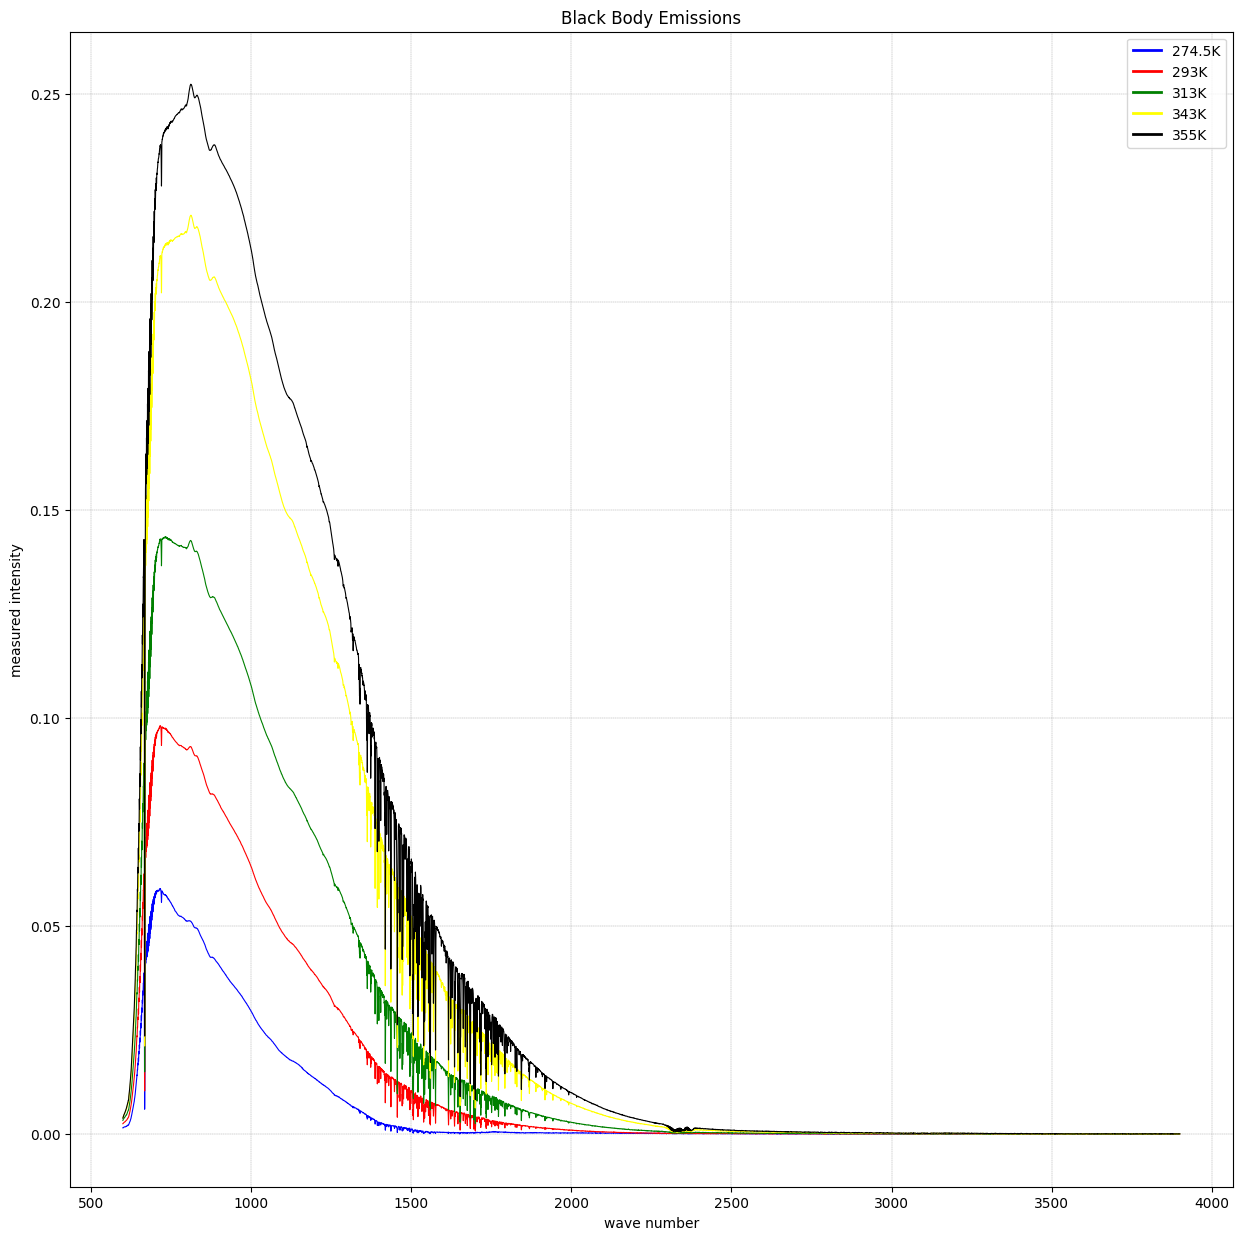

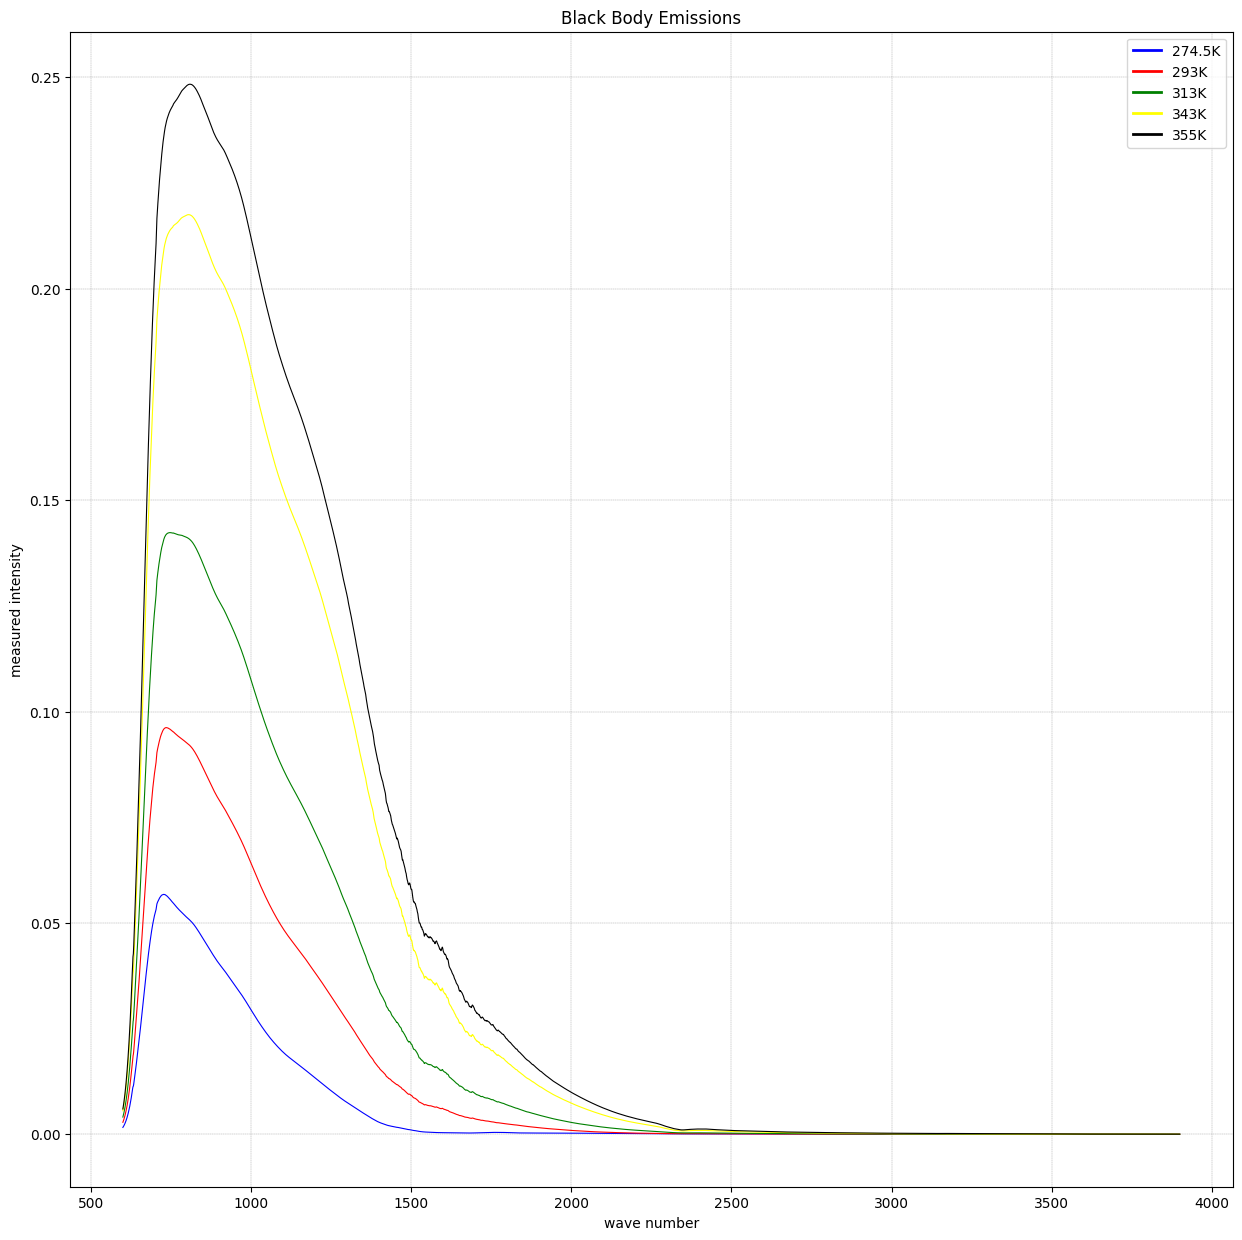

In [6]:
# Temperature acquired during the lab
T1 = 274.5
T2 = 293
T3 = 313
T4 = 343
T5 = 352

# Compute the blackbody radiation for the first five measurements
I_theory_273K = black_body(I_measured_273K[:, 0], T1)
I_theory_293K = black_body(I_measured_293K[:, 0], T2)
I_theory_313K = black_body(I_measured_313K[:, 0], T3)
I_theory_343K = black_body(I_measured_343K[:, 0], T4)
I_theory_355K = black_body(I_measured_355K[:, 0], T5)


# Apply the moving average to filter out noise

window_size = 300 

I_measured_273K_filtered = moving_average(I_measured_273K[:, 1], window_size)
I_measured_293K_filtered = moving_average(I_measured_293K[:, 1], window_size)
I_measured_313K_filtered = moving_average(I_measured_313K[:, 1], window_size)
I_measured_343K_filtered = moving_average(I_measured_343K[:, 1], window_size)
I_measured_355K_filtered = moving_average(I_measured_355K[:, 1], window_size)

# Re-arranging the filtered value in a 2d matrix shape
I_measured_273K_filtered = np.column_stack((I_measured_273K[:, 0], I_measured_273K_filtered))
I_measured_293K_filtered = np.column_stack((I_measured_293K[:, 0], I_measured_293K_filtered))
I_measured_313K_filtered = np.column_stack((I_measured_313K[:, 0], I_measured_313K_filtered))
I_measured_343K_filtered = np.column_stack((I_measured_343K[:, 0], I_measured_343K_filtered))
I_measured_355K_filtered = np.column_stack((I_measured_355K[:, 0], I_measured_355K_filtered))

# Plot Non-filtered and Filtered values
axes = plot_points(I_measured_273K, I_measured_293K, I_measured_313K, I_measured_343K, I_measured_355K, True)
axes2 = plot_points(I_measured_273K_filtered, I_measured_293K_filtered, I_measured_313K_filtered, I_measured_343K_filtered, I_measured_355K_filtered, True)

### Slopes and Offset computation

In [7]:
#compute slopes and offsets

epsilon = 2e-6

slope1, offset1 = slp_and_off2(I_theory_273K, I_theory_293K, I_measured_273K_filtered[:, 1], I_measured_293K_filtered[:, 1], epsilon) 
slope2, offset2 = slp_and_off2(I_theory_313K, I_theory_343K, I_measured_313K_filtered[:, 1], I_measured_343K_filtered[:, 1], epsilon) 
slope3, offset3 = slp_and_off2(I_theory_273K, I_theory_313K, I_measured_273K_filtered[:, 1], I_measured_313K_filtered[:, 1], epsilon)
slope4, offset4 = slp_and_off2(I_theory_273K, I_theory_343K, I_measured_273K_filtered[:, 1], I_measured_343K_filtered[:, 1], epsilon)


# compute the slope and offset average
slope = (slope1 + slope2 + slope3 + slope4)/4
offset = (offset1 + offset2 + offset3 + offset4)/4

#print slopes values
#print(f"Slopes: {slope1}\nOffsets: {offset1}")
#print(f"Slopes: {slope2}\nOffsets: {offset2}")
#print(f"Slopes: {slope3}\nOffsets: {offset3}")
#print(f"Slopes: {slope}\nOffsets: {offset}")

### Test of a calibrated spectra
In this section we want to compare the theoretical black body with temperature T5 and the measured one calibrated by the algorithm

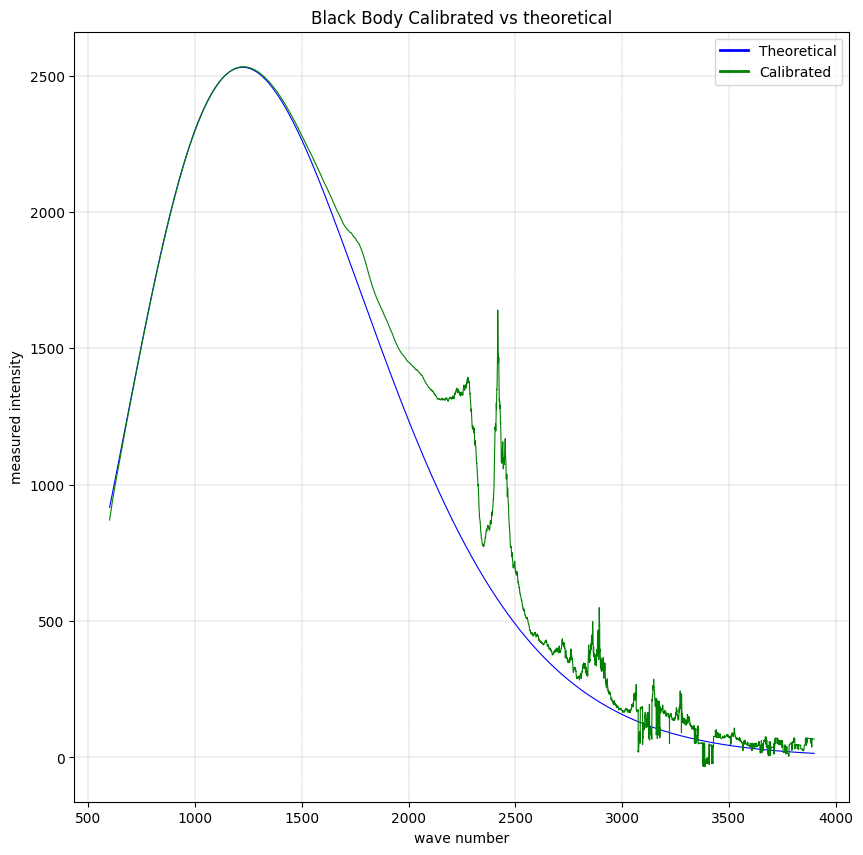

In [8]:
def calibration(slope, offset, I_measured):
    I_calibrated = slope*I_measured[:, 1] + offset
    return I_calibrated


# Create a test theoretical spectra at temperature T5
I_theory_355K = black_body(I_measured_355K[:, 0], T5)
I_theory_355K = np.column_stack((I_measured_355K[:, 0], I_theory_355K))

# Compute the calibrated spectra at temperature T3 with the given parameter
I_calibrated_355K = calibration(slope, offset, I_measured_355K_filtered)
#I_calibrated_355K = slope*I_measured_355K_filtered[:, 1] + offset
I_calibrated_355K = np.column_stack((I_measured_355K[:, 0], I_calibrated_355K))

axes = plot_calibrated_spectra_comparison(I_theory_355K, I_calibrated_355K)

### Fitting

In [9]:
from scipy.optimize import least_squares

def residuals(param, x_axes, I):
    T = param
    return I - black_body(x_axes, T)

#initial_guess = 293
#result = least_squares(residuals, initial_guess, args=(I_calibrated_355K[:, 0], I_calibrated_355K[:, 1]))

def temperature_fitter(x_axes, I_calibrated):
    initial_guess = 293
    result = least_squares(residuals, initial_guess, args=(x_axes, I_calibrated))
    fitted_T = result.x[0]
    
    return fitted_T

fitted_T = temperature_fitter(I_calibrated_355K[:, 0], I_calibrated_355K[:, 1])
    
print(f"fitted T: {fitted_T}")

fitted T: 355.7687021150452


In [10]:
I_stomach_calibrated = calibration(slope, offset, I_stomach)
I_sky_calibrated = calibration(slope, offset, I_sky)
I_wall_surface_calibrated = calibration(slope, offset, I_wall_surface)
I_wall_surface_outside_calibrated = calibration(slope, offset, I_wall_surface_outside)
I_additional_surface_outside_calibrated = calibration(slope, offset, I_additional_surface_outside)

fitted_stomach_T = temperature_fitter(I_stomach[:, 0], I_stomach_calibrated)
fitted_sky_T = temperature_fitter(I_sky[:, 0], I_sky_calibrated)
fitted_wall_T = temperature_fitter(I_wall_surface[:, 0], I_wall_surface_calibrated)
fitted_outside_wall_T = temperature_fitter(I_wall_surface_outside[:, 0], I_wall_surface_outside_calibrated)
fitted_additional_surface_outside_T = temperature_fitter(I_additional_surface_outside[:, 0], I_additional_surface_outside_calibrated)


print(f"Stomach T: {fitted_stomach_T - 273.15}C")
print(f"Sky T: {fitted_sky_T - 273.15}C")
print(f"inside wall T: {fitted_wall_T - 273.15}C")
print(f"outside wall T: {fitted_outside_wall_T - 273.15}C")
print(f"additional surface outside T: {fitted_additional_surface_outside_T - 273.15}C")


Stomach T: 30.792203734047973C
Sky T: 1.336774492672646C
inside wall T: 19.92850773587321C
outside wall T: 8.88985255411643C
additional surface outside T: 8.73199663680515C


### Ammonia Cross Section

A to sigma conversion factor : 9.31465109174741e-22


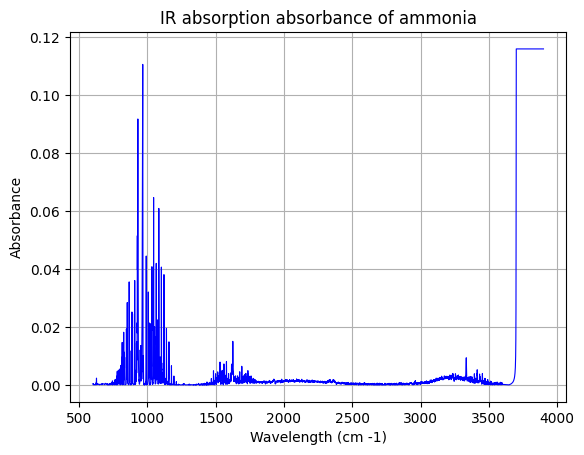

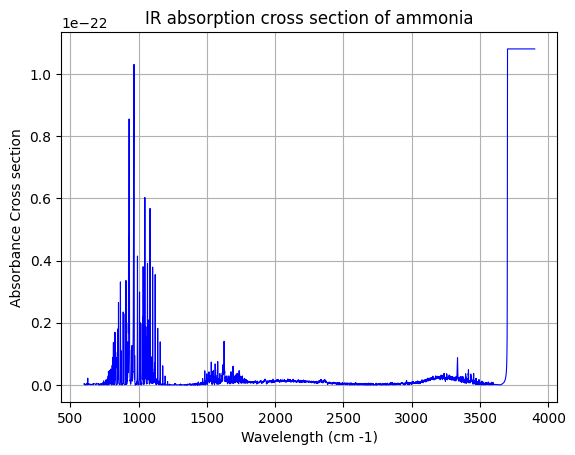

In [11]:
from scipy.interpolate import CubicSpline
import pandas as pd

k = scipy.constants.k

A_y_full = A[:, 1]

# Creating a full Nan array
A_y = np.full_like(A_y_full, np.nan)

# Fill A_y only when A_y_full is positive
for i in range(len(A_y_full)):
    if A_y_full[i] > 0:  # Check A_y_full values
        A_y[i] = A_y_full[i]

#Replace A_y with linear interpolation
A_y_series = pd.Series(A_y) # Convert A_y to a pandas Series
# Interpolate to fill NaN values using linear interpolation
A_y = A_y_series.interpolate(method='linear', limit_direction='forward').to_numpy()
# Ensure no NaNs remain (fill any edge NaNs with the nearest values)
A_y = np.nan_to_num(A_y, nan=0)  

#A_y = -np.log10(A_y)
A_y = np.interp(I_sky[:, 0], A[:, 0], A_y)

A_to_sigma_conversion_factor = 1 / ( ((10**5)/(k*293)) * 10**(-4) * 1 * np.log10(np.e) )
cross_section_interpolated = A_y *A_to_sigma_conversion_factor
print(f"A to sigma conversion factor : {A_to_sigma_conversion_factor}")

plt.plot(I_sky[:, 0], A_y, color="blue", lw="0.8")

plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Absorbance")
plt.title("IR absorption absorbance of ammonia")
plt.grid(True)

# Show plot
plt.show()


plt.plot(I_sky[:, 0], cross_section_interpolated, color="blue", lw="0.8")

plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Absorbance Cross section")
plt.title("IR absorption cross section of ammonia")
plt.grid(True)

# Show plot
plt.show()


### Concentration calculation

In [12]:
def remove_negative(vector):
    A_y_full = A[:, 1]

    # Creating a full Nan array
    clean = np.full_like(vector, np.nan)

    # Fill only the value is positive
    for i in range(len(vector)):
        if vector[i] > 0:  # Check values
            clean[i] = vector[i]

    #Replace with linear interpolation
    clean_series = pd.Series(clean) # Convert to a pandas Series
    # Interpolate to fill NaN values using linear interpolation
    clean = clean_series.interpolate(method='linear', limit_direction='forward').to_numpy()
    # Ensure no NaNs remain (fill any edge NaNs with the nearest values)
    clean = np.nan_to_num(clean, nan=0)
    
    return clean

    
def concentration(sigma , I_obs , background, T_background):
    
    T_cloud = 20.8 + 273.15 #using measured room temperature for temperature of cloud
    x_cloud = 0.26          #measured length of the cloud

    #if no background is provided use blackbody radiation
    B_cloud      = black_body(I_sky[:, 0] , T_cloud)
    B_background = black_body(I_sky[:, 0] , T_background) if background is None else background

    trans = (I_obs - B_cloud)/(B_background - B_cloud)
    trans = remove_negative(trans)
    
    c_cloud = (-1/(x_cloud * sigma) ) * np.log( trans )
    
    return trans , c_cloud

# 4 spectra for concentration of ammonia
# sky as background , stomach as background and 2 control spectres

# Stomach withouth and with ammonia cloud comparison
I_stomach_calibrated = calibration(slope, offset, I_stomach_empty)
I_stomach_ammonia_calibrated = calibration(slope, offset, I_stomach_ammonia)

trans_stomach_empty , concentration_stomach_empty = \
    concentration(cross_section_interpolated, I_stomach_calibrated, None,fitted_stomach_T)
absorbance_stomach_empty = -np.log10(trans_stomach_empty)

trans_stomach_ammonia , concentration_stomach_ammonia = \
    concentration(cross_section_interpolated, I_stomach_ammonia_calibrated, I_stomach_calibrated,fitted_stomach_T)
absorbance_stomach_ammonia = -np.log10(trans_stomach_ammonia)

# Sky withouth and with ammonia cloud comparison
I_sky_calibrated = calibration(slope, offset, I_sky)
I_sky_ammonia_calibrated = calibration(slope, offset, I_sky_ammonia)

trans_sky_empty , concentration_sky_empty = \
    concentration(cross_section_interpolated, I_sky_calibrated, None,fitted_sky_T)
absorbance_sky_empty = -np.log10(trans_sky_empty)

trans_sky_ammonia , concentration_sky_ammonia = \
    concentration(cross_section_interpolated, I_sky_ammonia_calibrated, I_sky_calibrated,fitted_sky_T)
absorbance_sky_ammonia = -np.log10(trans_sky_ammonia)
str = (
f"""
c_cloud_1 = {concentration_stomach_empty},
c_cloud_2 = {concentration_stomach_ammonia},
c_cloud_3 = {concentration_sky_empty},
c_cloud_4 = {concentration_sky_ammonia},
""")

print(str)

inverting_concentration_stomach = concentration_stomach_ammonia - concentration_stomach_empty
inverting_concentration_sky     = concentration_sky_ammonia - concentration_sky_empty





c_cloud_1 = [ 2.43699207e+25  3.53020772e+25  6.41869878e+25 ... -1.71524815e+23
 -1.72411836e+23 -1.72440150e+23],
c_cloud_2 = [-2.75019700e+24 -1.28197438e+25 -4.06382333e+25 ... -8.58706773e+20
  8.58699938e+20  1.73861383e+21],
c_cloud_3 = [ 9.50672851e+23  9.21863352e+23  6.56957006e+23 ... -1.47264403e+23
 -1.47264403e+23 -1.47264403e+23],
c_cloud_4 = [-1.24305673e+23 -1.19817997e+23 -0.00000000e+00 ...  1.69718543e+21
 -1.69717208e+21 -1.69715874e+21],



### Plotting concentration

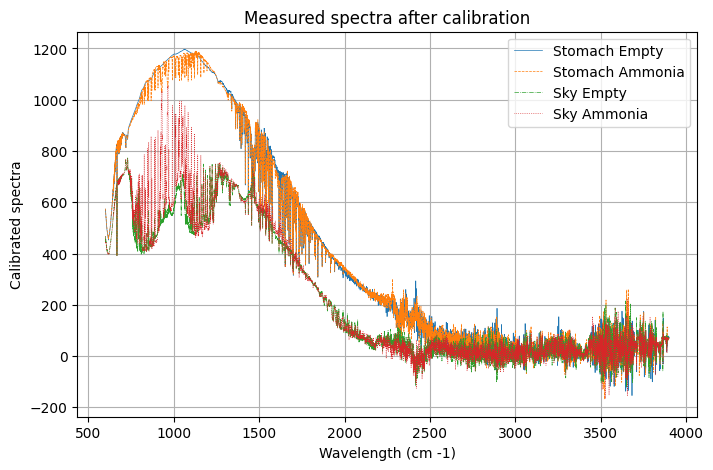

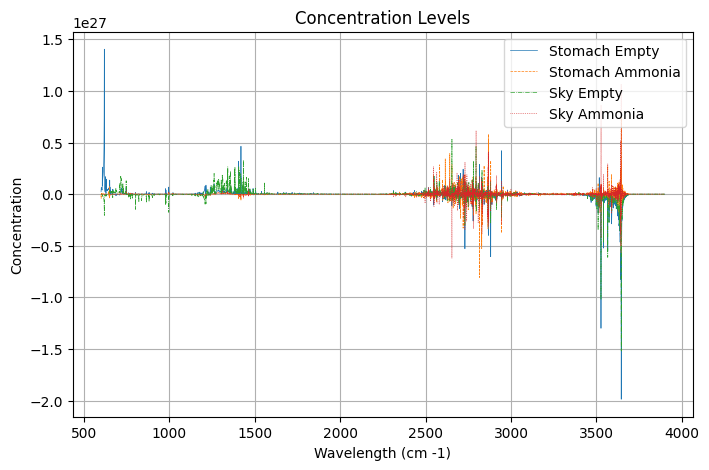

In [13]:
############ spectra      ##########
c_cloud_1 = np.array(I_stomach_calibrated)
c_cloud_2 = np.array(I_stomach_ammonia_calibrated)
c_cloud_3 = np.array(I_sky_calibrated)
c_cloud_4 = np.array(I_sky_ammonia_calibrated)

# Generate x-axis values (assuming all vectors have the same length)
#x = np.arange(len(c_cloud_1))
x = I_sky[:,0]

# Plot each vector
plt.figure(figsize=(8, 5))
plt.plot(x, c_cloud_1, linewidth = 0.5, linestyle='-', label="Stomach Empty")
plt.plot(x, c_cloud_2, linewidth = 0.5, linestyle='--', label="Stomach Ammonia")
plt.plot(x, c_cloud_3, linewidth = 0.5, linestyle='-.', label="Sky Empty")
plt.plot(x, c_cloud_4, linewidth = 0.5, linestyle=':', label="Sky Ammonia")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Calibrated spectra")
plt.title("Measured spectra after calibration")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)

# Show plot
plt.show()
############concentrations###########
c_cloud_1 = np.array(concentration_stomach_empty)
c_cloud_2 = np.array(concentration_stomach_ammonia)
c_cloud_3 = np.array(concentration_sky_empty)
c_cloud_4 = np.array(concentration_sky_ammonia)

# Generate x-axis values (assuming all vectors have the same length)
#x = np.arange(len(c_cloud_1))
x = I_sky[:,0]

# Plot each vector
plt.figure(figsize=(8, 5))
plt.plot(x, c_cloud_1, linewidth = 0.5, linestyle='-', label="Stomach Empty")
plt.plot(x, c_cloud_2, linewidth = 0.5, linestyle='--', label="Stomach Ammonia")
plt.plot(x, c_cloud_3, linewidth = 0.5, linestyle='-.', label="Sky Empty")
plt.plot(x, c_cloud_4, linewidth = 0.5, linestyle=':', label="Sky Ammonia")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Concentration")
plt.title("Concentration Levels")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)

# Show plot
plt.show()
 

### Plotting transmittance and absorbance

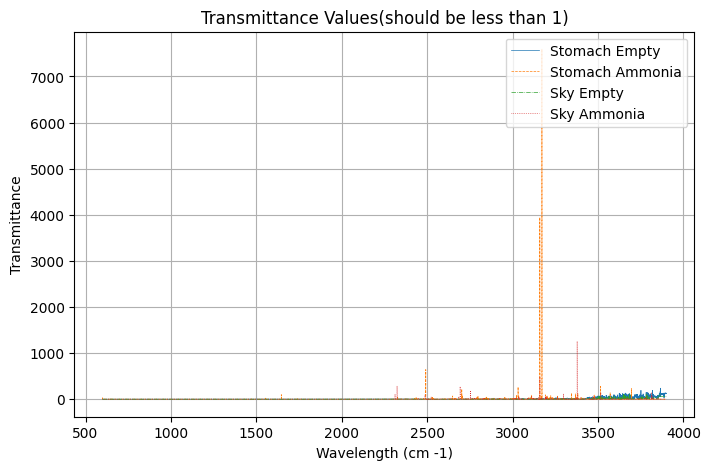

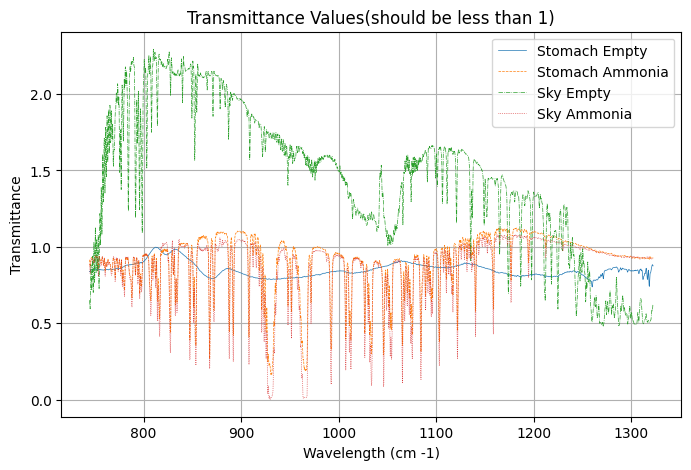

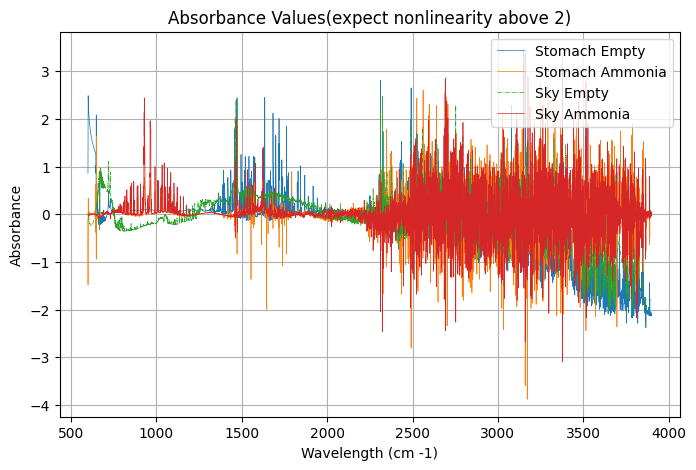

932 cm-1 at index = 1378
transmittance stomach 932 = 0.20967274357651366
transmittance sky     932 = 0.027152603308495782
cross section         932 = 6.127994326560145e-23
967 cm-1 at index = 1523
transmittance stomach 967 = 0.19392308621087248
transmittance sky     967 = 0.01641513012688232
cross section         967 = 1.0307633431891029e-22


In [14]:
##########  transmitance  ############
c_cloud_1 = np.array(trans_stomach_empty)
c_cloud_2 = np.array(trans_stomach_ammonia)
c_cloud_3 = np.array(trans_sky_empty)
c_cloud_4 = np.array(trans_sky_ammonia)

x = I_sky[:,0]   #wavenumber vector

# Plot each vector
plt.figure(figsize=(8, 5))
plt.plot(x, c_cloud_1, linewidth = 0.5, linestyle='-', label="Stomach Empty")
plt.plot(x, c_cloud_2, linewidth = 0.5, linestyle='--', label="Stomach Ammonia")
plt.plot(x, c_cloud_3, linewidth = 0.5, linestyle='-.', label="Sky Empty")
plt.plot(x, c_cloud_4, linewidth = 0.5, linestyle=':', label="Sky Ammonia")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Transmittance")
plt.title("Transmittance Values(should be less than 1)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)

# Show plot
plt.show()

############ transmittance but trimmed at the x axis  ##########
trim_left  = 600
trim_right = 3000
c_cloud_1 = np.array(trans_stomach_empty[trim_left:trim_right])
c_cloud_2 = np.array(trans_stomach_ammonia[trim_left:trim_right])
c_cloud_3 = np.array(trans_sky_empty[trim_left:trim_right])
c_cloud_4 = np.array(trans_sky_ammonia[trim_left:trim_right])

x = I_sky[trim_left:trim_right,0] #wavenumber vector

# Plot each vector
plt.figure(figsize=(8, 5))
plt.plot(x, c_cloud_1, linewidth = 0.5, linestyle='-', label="Stomach Empty")
plt.plot(x, c_cloud_2, linewidth = 0.5, linestyle='--', label="Stomach Ammonia")
plt.plot(x, c_cloud_3, linewidth = 0.5, linestyle='-.', label="Sky Empty")
plt.plot(x, c_cloud_4, linewidth = 0.5, linestyle=':', label="Sky Ammonia")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Transmittance")
plt.title("Transmittance Values(should be less than 1)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)

# Show plot
plt.show()

##########  absorbance  ############
c_cloud_1 = np.array(absorbance_stomach_empty)
c_cloud_2 = np.array(absorbance_stomach_ammonia)
c_cloud_3 = np.array(absorbance_sky_empty)
c_cloud_4 = np.array(absorbance_sky_ammonia)


x = I_sky[:,0]   #wavenumber vector

# Plot each vector
plt.figure(figsize=(8, 5))
plt.plot(x, c_cloud_1, linewidth = 0.5, linestyle='-', label="Stomach Empty")
plt.plot(x, c_cloud_2, linewidth = 0.5, linestyle='-', label="Stomach Ammonia")
plt.plot(x, c_cloud_3, linewidth = 0.5, linestyle='-.', label="Sky Empty")
plt.plot(x, c_cloud_4, linewidth = 0.5, linestyle='-', label="Sky Ammonia")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Absorbance")
plt.title("Absorbance Values(expect nonlinearity above 2)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)

# Show plot
plt.show()

# From this plots we can see that above 2200 cm-1 the results have no information( transmittance greater than 1 = negative absorbances)
# From a book I got "Fourier Transform Infrared Spectrometry, Peter R Griffiths, James A. de Haseth, Wiley 2007"
# Linearity of absorbance and concentration is mantained for A < 2
# Max absorbance in spectral range used for quantitative analysis should not exceed 0.7
# To measure the concetration(from just one point) we must choose points where A < 0.7, positive and we avoid the water and CO2 bands


closest_index_932 = (np.abs(I_sky[:,0] - 932)).argmin()
print(f"932 cm-1 at index = {closest_index_932}")
print(f"transmittance stomach 932 = {trans_stomach_ammonia[closest_index_932]}")
print(f"transmittance sky     932 = {trans_sky_ammonia[closest_index_932]}")
print(f"cross section         932 = {cross_section_interpolated[closest_index_932]}")

closest_index_967 = (np.abs(I_sky[:,0] - 967)).argmin()
print(f"967 cm-1 at index = {closest_index_967}")
print(f"transmittance stomach 967 = {trans_stomach_ammonia[closest_index_967]}")
print(f"transmittance sky     967 = {trans_sky_ammonia[closest_index_967]}")
print(f"cross section         967 = {cross_section_interpolated[closest_index_967]}")





### Loading base spectra

absorbance_ammonia_max = 1.0804995266426996e-22


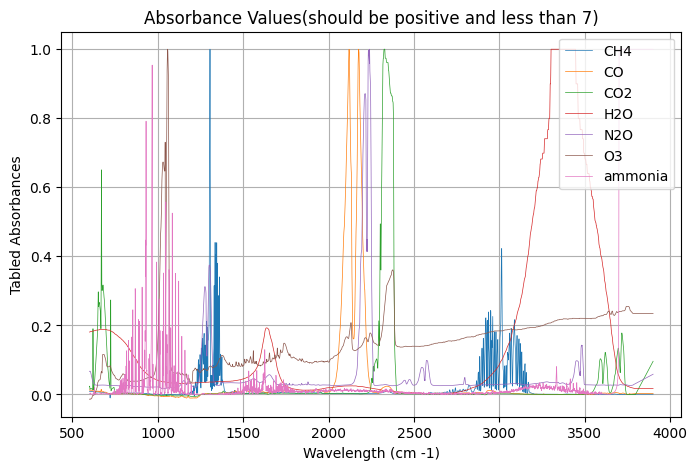

In [15]:
import csv
from scipy.interpolate import interp1d

def read_csv_first_two_columns(file_path):
    """
    Reads a CSV file and returns a 2D list containing only the first two columns.
    
    :param file_path: Path to the CSV file
    :return: A list of lists with the first two columns of the CSV file
    """
    data = []
    
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) >= 2:  # Ensure there are at least two columns
                data.append([float(row[0]), float(row[1])])
    
    return np.array(data)

def trans_raw_to_absorbance_raw (trans_raw):
    absorbance = np.full_like(trans_raw, np.nan)
    absorbance[:,0] = trans_raw[:,0]
    absorbance[:,1] = - np.log10(trans_raw[:,1])

    return absorbance

def interpolate_to_scale (large_spectrum):
    wavelength_large, intensity_large = large_spectrum[:, 0], large_spectrum[:, 1]
    wavelength_our = I_sky[:,0]

    # Interpolate CH4 spectrum to match the wavelengths of NH3
    interpolator = interp1d(wavelength_large, intensity_large, kind='linear', fill_value="extrapolate")

    # Generate new CH4 intensities based on NH3 wavelengths
    interpolated_large = interpolator(wavelength_our)
    interpolated_large = np.nan_to_num(interpolated_large, nan=0)


    return interpolated_large

trans_CH4_raw = read_csv_first_two_columns("base_spectra/CH4.csv")
trans_CO_raw  = read_csv_first_two_columns("base_spectra/CO.csv")
trans_CO2_raw = read_csv_first_two_columns("base_spectra/CO2.csv")
trans_H2O_raw = read_csv_first_two_columns("base_spectra/H2O.csv")
trans_N2O_raw = read_csv_first_two_columns("base_spectra/N2O.csv")
trans_O3_raw = read_csv_first_two_columns("base_spectra/O3.csv")

#we are fitting cross sections instead of absobances, but the two are proportional, only the shapes matter
absorbance_CH4_raw = trans_raw_to_absorbance_raw(trans_CH4_raw)
absorbance_CO_raw = trans_raw_to_absorbance_raw(trans_CO_raw)
absorbance_CO2_raw = trans_raw_to_absorbance_raw(trans_CO2_raw)
absorbance_H2O_raw = trans_raw_to_absorbance_raw(trans_H2O_raw)
absorbance_N2O_raw = trans_raw_to_absorbance_raw(trans_N2O_raw)
absorbance_O3_raw = trans_raw_to_absorbance_raw(trans_O3_raw)

absorbance_CH4 = interpolate_to_scale(absorbance_CH4_raw)
absorbance_CO  = interpolate_to_scale(absorbance_CO_raw)
absorbance_CO2 = interpolate_to_scale(absorbance_CO2_raw)
absorbance_H2O = interpolate_to_scale(absorbance_H2O_raw)
absorbance_N2O = interpolate_to_scale(absorbance_N2O_raw)
absorbance_O3  = interpolate_to_scale(absorbance_O3_raw)
cross_section_ammonia = cross_section_interpolated
#These names are wrong but they dont matter, only the ammonia matters

###########  Normalize the absorbances for better fitting  ###############
absorbance_CH4_max     = max(absorbance_CH4)
absorbance_CO_max      = max(absorbance_CO)
absorbance_CO2_max     = max(absorbance_CO2)
absorbance_H2O_max     = max(absorbance_H2O)
absorbance_N2O_max     = max(absorbance_N2O)
absorbance_O3_max      = max(absorbance_O3)
cross_section_ammonia_max = max(cross_section_ammonia)

print(f"absorbance_ammonia_max = {cross_section_ammonia_max}")

absorbance_CH4     = absorbance_CH4/absorbance_CH4_max
absorbance_CO      = absorbance_CO/absorbance_CO_max 
absorbance_CO2     = absorbance_CO2/absorbance_CO2_max 
absorbance_H2O     = absorbance_H2O/ absorbance_H2O_max 
absorbance_N2O     = absorbance_N2O / absorbance_N2O_max 
absorbance_O3      = absorbance_O3 /absorbance_O3_max   
cross_section_ammonia = cross_section_ammonia/cross_section_ammonia_max



##########  absorbance  ############
c_cloud_1 = np.array(absorbance_CH4)
c_cloud_2 = np.array(absorbance_CO)
c_cloud_3 = np.array(absorbance_CO2)
c_cloud_4 = np.array(absorbance_H2O)
c_cloud_5 = np.array(absorbance_N2O)
c_cloud_6 = np.array(absorbance_O3)
c_cloud_7 = np.array(cross_section_ammonia)

x = I_sky[:,0]  #wavenumber vector

# Plot each absorbance
plt.figure(figsize=(8, 5))
plt.plot(x, c_cloud_1, linewidth = 0.5, linestyle='-', label="CH4")
plt.plot(x, c_cloud_2, linewidth = 0.5, linestyle='-', label="CO")
plt.plot(x, c_cloud_3, linewidth = 0.5, linestyle='-', label="CO2")
plt.plot(x, c_cloud_4, linewidth = 0.5, linestyle='-', label="H2O")
plt.plot(x, c_cloud_5, linewidth = 0.5, linestyle='-', label="N2O")
plt.plot(x, c_cloud_6, linewidth = 0.5, linestyle='-', label="O3")
plt.plot(x, c_cloud_7, linewidth = 0.5, linestyle='-', label="ammonia")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Tabled Absorbances")
plt.title("Absorbance Values(should be positive and less than 7)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)

# Show plot
plt.show()




### Finding concentration with spectrum fitting

False False
R-squared (R²): 0.8892145960286839
Fitted coefficients: [ 1.11661415 -0.59340241  2.33642451  2.2623537  -0.75107564 -4.89753485
  0.03727084]


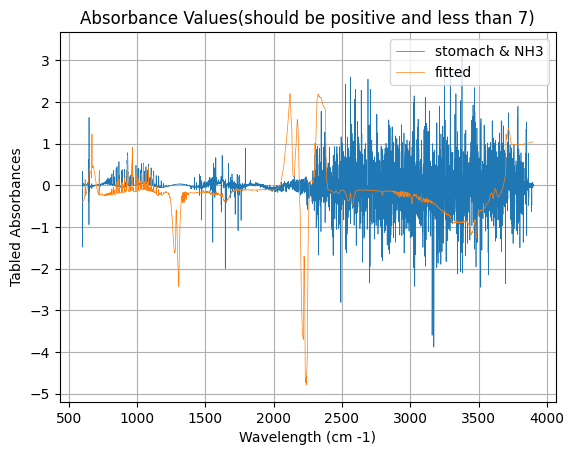

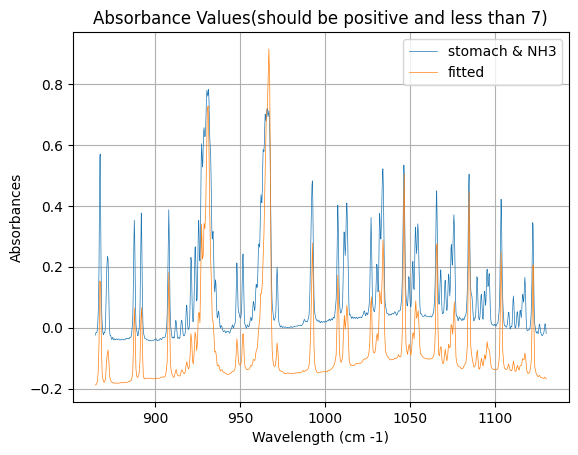

Average concentration from fitting stomach: 3.2814085275993023e+22
Median concentration from fitting stomach: 6.552146785554242e+22


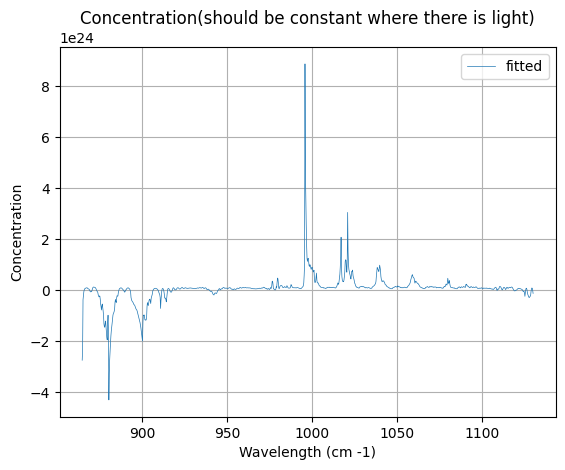

In [16]:
# We need to fit 2 spectra absorbance_stomach_ammonia and absorbance_sky_ammonia
# We start with the stomach

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

trim_left = 1100
trim_right = 2200
X = np.vstack([
    cross_section_ammonia[trim_left:trim_right],
    absorbance_CH4[trim_left:trim_right],
    absorbance_CO[trim_left:trim_right],
    absorbance_CO2[trim_left:trim_right],
    absorbance_H2O[trim_left:trim_right],
    absorbance_N2O[trim_left:trim_right],
    absorbance_O3[trim_left:trim_right]
]).T  # Transpose to match dimensions

# Target absorbance spectrum is the stomach background with ammonia
y = absorbance_stomach_ammonia[trim_left:trim_right]

print(np.isnan(cross_section_ammonia).any(), np.isinf(cross_section_ammonia).any())


# Ridge regression with a very small regularization parameter to avoid overfitting
ridge = Ridge(alpha=10e-4)  # alpha is the regularization strength, usually less than 1 but try...
ridge.fit(X, y)
coefficients = ridge.coef_
r2 = r2_score(y, ridge.predict(X))
print(f"R-squared (R²): {r2}")

# coefficients contain the contribution of each absorbance spectra
print("Fitted coefficients:", coefficients)


X = np.vstack([
    cross_section_ammonia,
    absorbance_CH4,
    absorbance_CO,
    absorbance_CO2,
    absorbance_H2O,
    absorbance_N2O,
    absorbance_O3
]).T

# We can now use the coefficients to get the fitted absorbance spectrum
fitted_spectrum = np.dot(X, coefficients)

plt.plot(x, absorbance_stomach_ammonia, linewidth = 0.5, linestyle='-', label="stomach & NH3")
plt.plot(x, fitted_spectrum, linewidth = 0.5, linestyle='-', label="fitted")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Tabled Absorbances")
plt.title("Absorbance Values(should be positive and less than 7)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)
plt.show()


plt.plot(x[trim_left:trim_right], absorbance_stomach_ammonia[trim_left:trim_right], linewidth = 0.5, linestyle='-', label="stomach & NH3")
plt.plot(x[trim_left:trim_right], fitted_spectrum[trim_left:trim_right], linewidth = 0.5, linestyle='-', label="fitted")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Absorbances")
plt.title("Absorbance Values(should be positive and less than 7)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)
plt.show()

x_cloud = 0.26
concentration_fitted_stomach = (coefficients[0] * absorbance_stomach_ammonia)/(cross_section_interpolated * x_cloud)
print(f"Average concentration from fitting stomach: {np.average(concentration_fitted_stomach[trim_left:trim_right])}")
print(f"Median concentration from fitting stomach: {np.median(concentration_fitted_stomach[trim_left:trim_right])}")

plt.plot(x[trim_left:trim_right], concentration_fitted_stomach[trim_left:trim_right] , linewidth = 0.5, linestyle='-', label="fitted")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Concentration")
plt.title("Concentration(should be constant where there is light)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)
plt.show()




False False
R-squared (R²): 0.8923669913677718
Fitted coefficients: [ 2.528882    3.92452589  8.94805983  0.80137253 -1.72868891 -2.37797304
  0.03473733]


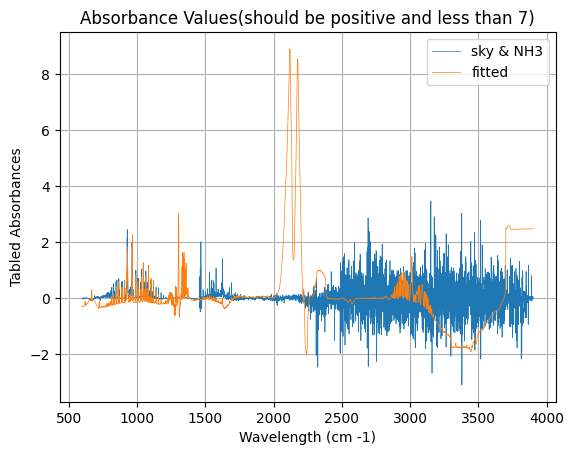

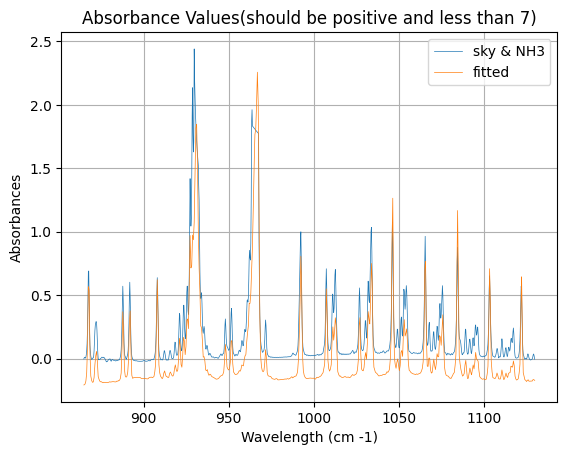

Average concentration from fitting stomach: 7.4316584242075866e+22
Median concentration from fitting stomach: 1.483915106758534e+23


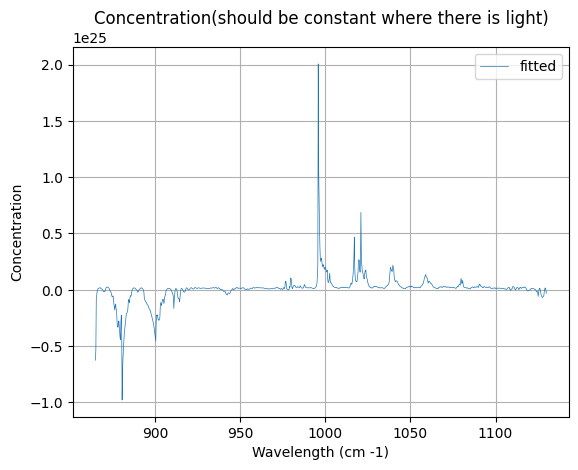

In [17]:
# Repeat with sky as background

trim_left = 1100
trim_right = 2200
X = np.vstack([
    cross_section_ammonia[trim_left:trim_right],
    absorbance_CH4[trim_left:trim_right],
    absorbance_CO[trim_left:trim_right],
    absorbance_CO2[trim_left:trim_right],
    absorbance_H2O[trim_left:trim_right],
    absorbance_N2O[trim_left:trim_right],
    absorbance_O3[trim_left:trim_right]
]).T  # Transpose to match dimensions

# Target absorbance spectrum is sky background with ammonia
y = absorbance_sky_ammonia[trim_left:trim_right]

print(np.isnan(cross_section_ammonia).any(), np.isinf(cross_section_ammonia).any())

# Ridge regression with a very small regularization parameter to avoid overfitting
ridge = Ridge(alpha=10e-4)  # alpha is the regularization strength, usually less than 1 but try...
ridge.fit(X, y)
coefficients = ridge.coef_
r2 = r2_score(y, ridge.predict(X))
print(f"R-squared (R²): {r2}")

# Solve for coefficients using least squares
#coefficients, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)

# coefficients contain the contribution of each absorbance spectra
print("Fitted coefficients:", coefficients)


X = np.vstack([
    cross_section_ammonia,
    absorbance_CH4,
    absorbance_CO,
    absorbance_CO2,
    absorbance_H2O,
    absorbance_N2O,
    absorbance_O3
]).T
# You can now use the coefficients to get the fitted absorbance spectrum
fitted_spectrum = np.dot(X, coefficients)

plt.plot(x, absorbance_sky_ammonia, linewidth = 0.5, linestyle='-', label="sky & NH3")
plt.plot(x, fitted_spectrum, linewidth = 0.5, linestyle='-', label="fitted")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Tabled Absorbances")
plt.title("Absorbance Values(should be positive and less than 7)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)
plt.show()


plt.plot(x[trim_left:trim_right], absorbance_sky_ammonia[trim_left:trim_right], linewidth = 0.5, linestyle='-', label="sky & NH3")
plt.plot(x[trim_left:trim_right], fitted_spectrum[trim_left:trim_right], linewidth = 0.5, linestyle='-', label="fitted")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Absorbances")
plt.title("Absorbance Values(should be positive and less than 7)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)
plt.show()

x_cloud = 0.26
concentration_fitted_stomach = (coefficients[0] * absorbance_stomach_ammonia)/(cross_section_interpolated * x_cloud)
print(f"Average concentration from fitting stomach: {np.average(concentration_fitted_stomach[trim_left:trim_right])}")
print(f"Median concentration from fitting stomach: {np.median(concentration_fitted_stomach[trim_left:trim_right])}")

plt.plot(x[trim_left:trim_right], concentration_fitted_stomach[trim_left:trim_right] , linewidth = 0.5, linestyle='-', label="fitted")

# Labels and title
plt.xlabel("Wavelength (cm -1)")
plt.ylabel("Concentration")
plt.title("Concentration(should be constant where there is light)")
plt.legend(loc="upper right")  # Set fixed legend position
plt.grid(True)
plt.show()